# Bifurcation analysis

In [334]:
from functools import partial 
from collections import defaultdict 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.integrate
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import sympy as sp
from sympy import latex
from scipy.optimize import fsolve, root
from IPython.display import display, Math
# %matplotlib inline

from potencial import get_expressions

plots_dir = 'plots/bifurcations/'

## Importing the functions and parameter definition
We're using for a start:

\begin{align}
c = 1, \quad g = 1, \quad s_0 = 1, \quad I_L = 1, \quad I_C = 1, \quad I_R = 1, \quad I_I = 1/3, \quad s_L = 0, \quad s_C = 0, \quad s_R = 0
\end{align}



In [335]:
X1, X2, I_L, I_C, I_R = sp.symbols('X1 X2 I_L I_C I_R')
values = {
    "tau": 1,
    "c": 1,
    "g": 1,
    "s0": 1,
    "IL": 1,
    "IC": 1,
    "IR": 1,
    "I_I": 1/4,
    "sL": 0,
    "sC": 0,
    "sR": 0,
}
potencial, F1, F2, H = get_expressions(values, type = "symbolic", substituted_I =  False)

_,F1_num, F2_num, H_num = get_expressions(values, type = "numeric", substituted_I =  False)

display(Math(r"F1 = " + latex(F1)))
display(Math(r"F2 = " + latex(F2)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Definitions

In [310]:
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center':'C5',
                    'Transcritical (Saddle-Node)':'C6'}

STABILITY_STYLE = {
    "Stable node": "-",
    "Stable focus": "-",
    "Unstable node": "--",
    "Unstable focus": "--",
    "Saddle": ":",
    "Center": "-.",
    "Transcritical (Saddle-Node)": "-."
}

In [278]:
def stability(J):
    det = np.linalg.det(J)
    tr  = np.trace(J)
    if np.isclose(tr, 0) and np.isclose(det, 0):
        return "Center"
    elif np.isclose(det, 0):
        return "Transcritical (Saddle-Node)"
    elif det < 0:
        return "Saddle"
    else:
        base = "Stable" if tr < 0 else "Unstable"
        return base + (" focus" if (tr**2 - 4*det) < 0 else " node")
    
def vectorize_constant(f): # Needed to vectorize the function after lambdification
    def fv(x):
        y = f(x)
        if np.isscalar(y) or np.ndim(y)==0:
            return np.full_like(np.array(x, dtype=float), float(y), dtype=float)
        return np.array(y, dtype=float)
    return fv


## Computing the equilibrium points

We first find the equilibrium points for any given $\bar{I}$

In [299]:
I = sp.symbols('I')
F1_s = F1.subs({I_L: I, I_C: I, I_R: I})
F2_s = F2.subs({I_L: I, I_C: I, I_R: I})
F2_s

# soluciones = sp.solve([F1_s, F2_s], [X1, X2], dict=True)
# soluciones

1.0*X1**2 + 0.75*X1 - 3.0*X2**2 + 1.0*X2*(5.78571428571429*I + 0.232142857142857) - 0.571428571428571*X2*(X1**2 + 3*X2**2) + 0.5*X2 + 0.125

In [242]:
def find_equilibria(F1_num, F2_num, I_value,
                    initial_guesses=None,
                    tol=1e-6,
                    grid_limits=(-5,5),
                    grid_points=10):

    def system(vars):
        x1, x2 = vars
        return [
            F1_num(x1, x2, I_value, I_value, I_value),
            F2_num(x1, x2, I_value, I_value, I_value)
        ]

    if initial_guesses is None:
        a, b = grid_limits
        xs = np.linspace(a, b, grid_points)
        ys = np.linspace(a, b, grid_points)
        initial_guesses = [(x, y) for x in xs for y in ys]

    equilibria = []
    for guess in initial_guesses:
        sol = root(system, guess)
        if sol.success and np.allclose(sol.fun, [0, 0], atol=tol):
            x1_sol, x2_sol = sol.x
            if not any(np.hypot(x1_sol - x, x2_sol - y) < tol for x, y in equilibria):
                equilibria.append((x1_sol, x2_sol))

    return equilibria

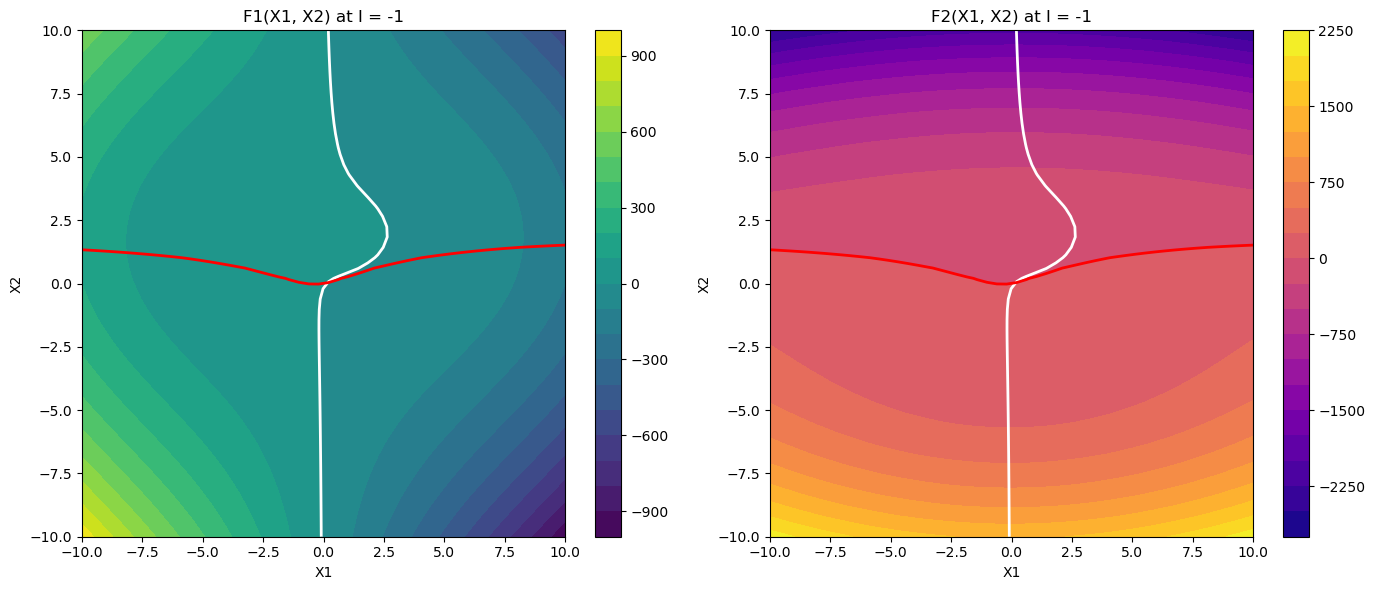

Found 1 equilibrium points at I = -1:
  Point 1: X1 = 0.191351, X2 = 0.058070, Type: Stable node


<Figure size 640x480 with 0 Axes>

In [294]:
from scipy.optimize import root
F1_num = sp.lambdify((X1, X2, I_L, I_C, I_R), F1, modules='numpy')
F2_num = sp.lambdify((X1, X2, I_L, I_C, I_R), F2, modules='numpy')
x1 = np.linspace(-10, 10, 50)
x2 = np.linspace(-10, 10, 50)
X1_grid, X2_grid = np.meshgrid(x1, x2)

# Choose a specific value for I
I_value = -1

# Compute F1 and F2 values
F1_values = np.zeros_like(X1_grid)
F2_values = np.zeros_like(X2_grid)

for i in range(len(x1)):
    for j in range(len(x2)):
        F1_values[j, i] = F1_num(X1_grid[j, i], X2_grid[j, i], I_value,I_value,I_value)
        F2_values[j, i] = F2_num(X1_grid[j, i], X2_grid[j, i], I_value, I_value, I_value)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# F1 plot with contours
cp1 = ax1.contourf(X1_grid, X2_grid, F1_values, cmap='viridis', levels=20)
ax1.contour(X1_grid, X2_grid, F1_values, colors='k', linestyles='-', linewidths=0.5, levels=[0])
ax1.set_title(f'F1(X1, X2) at I = {I_value}')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
plt.colorbar(cp1, ax=ax1)

# F2 plot with contours
cp2 = ax2.contourf(X1_grid, X2_grid, F2_values, cmap='plasma', levels=20)
ax2.contour(X1_grid, X2_grid, F2_values, colors='k', linestyles='-', linewidths=0.5, levels=[0])
ax2.set_title(f'F2(X1, X2) at I = {I_value}')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
plt.colorbar(cp2, ax=ax2)

# Overlay nullclines
ax1.contour(X1_grid, X2_grid, F1_values, levels=[0], colors='white', linestyles='-', linewidths=2)
ax1.contour(X1_grid, X2_grid, F2_values, levels=[0], colors='red', linestyles='-', linewidths=2)
ax2.contour(X1_grid, X2_grid, F1_values, levels=[0], colors='white', linestyles='-', linewidths=2)
ax2.contour(X1_grid, X2_grid, F2_values, levels=[0], colors='red', linestyles='-', linewidths=2)

plt.tight_layout()
plt.savefig(f'{plots_dir}F1_F2_nullclines_I_{I_value}.png', dpi=300)
plt.show()


# Find equilibrium points where F1=0 and F2=0
# First, find where F1_values and F2_values are close to zero
tol = 0.5  # Tolerance for considering a value as zero
zeros_mask = (np.abs(F1_values) < tol) & (np.abs(F2_values) < tol)
zero_indices = np.where(zeros_mask)

# Extract the equilibrium points
eq_points = []
if len(zero_indices[0]) > 0:
    for i, j in zip(zero_indices[1], zero_indices[0]):  # Note: x is column (j), y is row (i)
        x1_val = X1_grid[j, i]
        x2_val = X2_grid[j, i]
        # Compute actual F1 and F2 values at this point
        f1_val = F1_num(x1_val, x2_val, I_value, I_value, I_value)
        f2_val = F2_num(x1_val, x2_val, I_value, I_value, I_value)
        eq_points.append((x1_val, x2_val, f1_val, f2_val))

# Use root finding to refine the equilibrium points

def system(x):
    return [
        F1_num(x[0], x[1], I_value, I_value, I_value),
        F2_num(x[0], x[1], I_value, I_value, I_value)
    ]

# Use grid points as initial guesses
refined_eq_points = []
initial_points = []
if eq_points:
    initial_points = [(x, y) for x, y, _, _ in eq_points]
else:
    # Use a grid of initial guesses if no points were found
    x_guesses = np.linspace(-5, 5, 10)
    y_guesses = np.linspace(-5, 5, 10)
    for x_guess in x_guesses:
        for y_guess in y_guesses:
            initial_points.append((x_guess, y_guess))

# Solve for each initial point
for x0, y0 in initial_points:
    sol = root(system, [x0, y0])
    if sol.success and abs(sol.fun[0]) < 1e-8 and abs(sol.fun[1]) < 1e-8:
        # Check if this is a new point
        is_new = True
        for x, y in refined_eq_points:
            if abs(x - sol.x[0]) < 1e-6 and abs(y - sol.x[1]) < 1e-6:
                is_new = False
                break
        if is_new:
            refined_eq_points.append((sol.x[0], sol.x[1]))

# Add equilibrium points to the plots with stability information
if refined_eq_points:
    print(f"Found {len(refined_eq_points)} equilibrium points at I = {I_value}:")
    for i, (x1_val, x2_val) in enumerate(refined_eq_points):
        # Calculate the Jacobian matrix at this point
        jacobian = np.zeros((2, 2))
        
        # Numerical differentiation for Jacobian
        h = 1e-6
        jacobian[0, 0] = (F1_num(x1_val + h, x2_val, I_value, I_value, I_value) - 
                          F1_num(x1_val - h, x2_val, I_value, I_value, I_value)) / (2 * h)
        jacobian[0, 1] = (F1_num(x1_val, x2_val + h, I_value, I_value, I_value) - 
                          F1_num(x1_val, x2_val - h, I_value, I_value, I_value)) / (2 * h)
        jacobian[1, 0] = (F2_num(x1_val + h, x2_val, I_value, I_value, I_value) - 
                          F2_num(x1_val - h, x2_val, I_value, I_value, I_value)) / (2 * h)
        jacobian[1, 1] = (F2_num(x1_val, x2_val + h, I_value, I_value, I_value) - 
                          F2_num(x1_val, x2_val - h, I_value, I_value, I_value)) / (2 * h)
        
        # Determine stability
        stab_type = stability(jacobian)
        color = EQUILIBRIUM_COLOR[stab_type]
        
        print(f"  Point {i+1}: X1 = {x1_val:.6f}, X2 = {x2_val:.6f}, Type: {stab_type}")
        
        # Plot on both axes
        for a in [ax1, ax2]:
            a.scatter(x1_val, x2_val, color=color, s=100, 
                      marker='o', edgecolor='black', zorder=5, 
                      label=f'{stab_type}' if i == 0 else '')
            
# Create a legend for equilibrium points
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=EQUILIBRIUM_COLOR[t], 
                 markersize=10, label=t) for t in EQUILIBRIUM_COLOR if t in [s[2] for s in stab]]
ax1.legend(handles=handles, loc='upper right', title='Equilibrium Types')

plt.tight_layout()
plt.savefig(f'{plots_dir}F1_F2_nullclines_with_eq_I_{I_value}.png', dpi=300)
plt.show()

Now we put the solutions on a list and compute the Jacobian to find the stability of the points

In [295]:
vec = sp.Matrix([F1_s, F2_s])
J   = vec.jacobian([X1, X2])

J_funcs = []
for sol in soluciones:
    Jsub = J.subs(sol)
    J_funcs.append([
        sp.lambdify(I, sp.simplify(Jsub[i,j]), 'numpy')
        for i in range(2) for j in range(2)
    ])

f1_list = [sp.lambdify(I, sol[X1], 'numpy') for sol in soluciones]
f2_list = [sp.lambdify(I, sol[X2], 'numpy') for sol in soluciones]


f1_list = [vectorize_constant(f) for f in f1_list]
f2_list = [vectorize_constant(f) for f in f2_list]


## Plots with stability

/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_17966/4081788730.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right', fontsize='small')


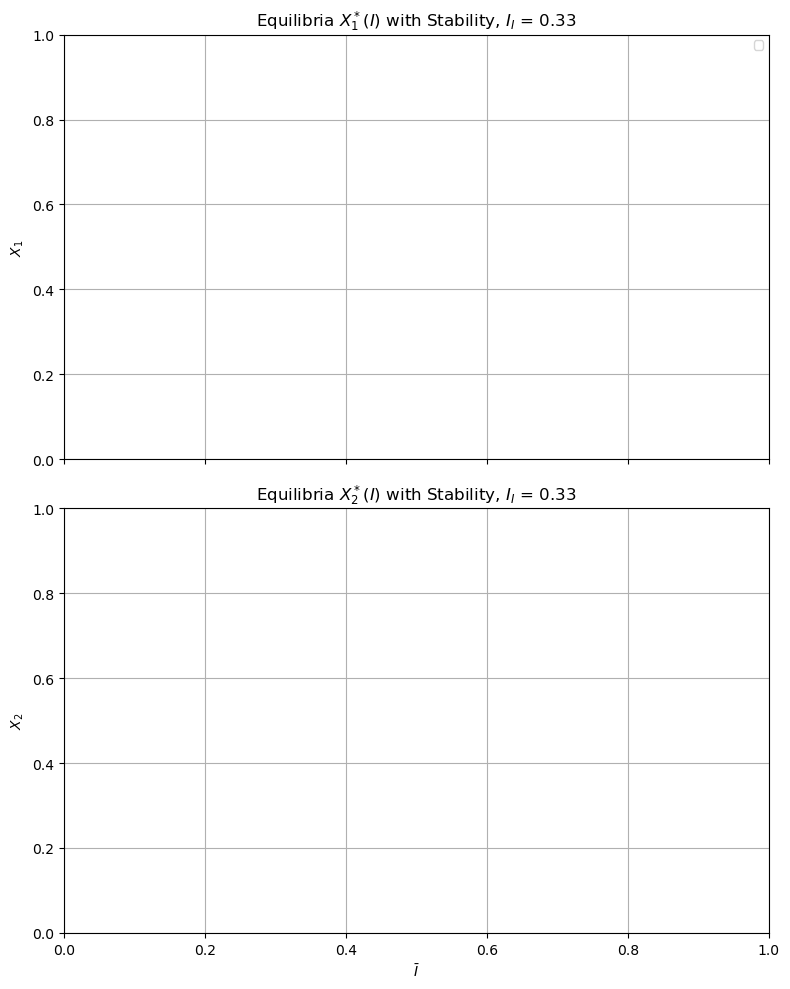

In [296]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

I_vals = np.linspace(-1, 2,10000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

tasks = [
    (ax1, f1_list, '$X_1$', f'Equilibria $X_1^*(I)$ with Stability, $I_I$ = {values["I_I"]:.2f}'),
    (ax2, f2_list, '$X_2$', f'Equilibria $X_2^*(I)$ with Stability, $I_I$ = {values["I_I"]:.2f}'),
]

for ax, f_list, y_label, title in tasks:
    plotted = set()
    for idx, (f, jf) in enumerate(zip(f_list, J_funcs), 1):
        y = f(I_vals)
        stab = [ stability(
                    np.array([[g(Iv) for g in jf[:2]],
                              [g(Iv) for g in jf[2:]]], float)
                )
                for Iv in I_vals ]
        
        start = 0
        for i in range(1, len(I_vals)+1):
            if i == len(I_vals) or stab[i] != stab[start]:
                s   = stab[start]
                seg = slice(start, i)
                ax.plot(
                    I_vals[seg], y[seg],
                    linestyle=STABILITY_STYLE[s],
                    color=EQUILIBRIUM_COLOR[s],
                    lw=1.5,
                    label=(s if s not in plotted else '_nolegend_')
                )
                plotted.add(s)
                start = i

    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.grid(True)

ax2.set_xlabel(r'$\bar{I}$')
ax1.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.savefig(f'{plots_dir}equilibria_stability_I_I_{values["I_I"]:.2f}.png', dpi=500)
plt.show()

In [307]:
import numpy as np
import sympy as sp


# 1) Defino símbolos y las dos ecuaciones como expresiones de Sympy
X1, X2, I = sp.symbols('X1 X2 I')

F1 = (2.0 + 1.71428571428571*I + 0.226190476190476 + 0.5)*X1 \
     - 0.19047619047619*X1*(X1**2 + 3*X2**2) \
     + 0.75*X2 + 0.125

F2 = X1**2 + 0.75*X1 \
     - 3.0*X2**2 \
     + (5.78571428571429*I + 0.232142857142857 + 0.5)*X2 \
     - 0.571428571428571*X2*(X1**2 + 3*X2**2) \
     + 0.125

# 2) Función que para un I dado busca raíces reales
def zeros_para_I(I_val, seeds=None, tol=1e-6):
    F1_I = F1.subs(I, I_val)
    F2_I = F2.subs(I, I_val)

    if seeds is None:
        pts = np.linspace(-3, 3, 5)
        seeds = [(x0, y0) for x0 in pts for y0 in pts]

    soluciones = []
    for x0, y0 in seeds:
        try:
            sol = sp.nsolve([F1_I, F2_I], [X1, X2], [x0, y0], tol=tol, maxsteps=50)
            sol = (float(sol[0]), float(sol[1]))
            if not any(np.hypot(sol[0] - x, sol[1] - y) < tol for x, y in soluciones):
                soluciones.append(sol)
        except Exception:
            # cualquier fallo (incluyendo falta de convergencia), lo saltamos
            continue

    return soluciones


# 3) Ejemplo: raíces para I=0, I=1 y I=2
for I_test in np.linspace(-1, 2, 50):
    sols = zeros_para_I(I_test)
    print(f"I = {I_test}: raíces encontradas ({len(sols)}): {sols}")


I = -1.0: raíces encontradas (4): [(-2.0179264603995812, 0.3157651006085316), (-2.0179274966139618, 0.3157653208152738), (-0.13039036270720217, 0.008686333008510355), (2.3222695821589916, 0.6663108035025064)]
I = -0.9387755102040817: raíces encontradas (3): [(-2.1250226509244587, 0.3557822428054652), (-0.11926958281336217, 0.01050248334657101), (2.4082131996138485, 0.7042890734121324)]
I = -0.8775510204081632: raíces encontradas (3): [(-2.225417219593226, 0.39505081029078054), (-0.11014732715992138, 0.012420896007571926), (2.4903169297226717, 0.7412627972057975)]
I = -0.8163265306122449: raíces encontradas (3): [(-2.3201014456998768, 0.43358562308168913), (-0.10257428017809399, 0.014499936258312236), (2.5689957592547827, 0.7773172226863738)]
I = -0.7551020408163265: raíces encontradas (3): [(-2.409843274714877, 0.4714069258837346), (-0.0962427007991389, 0.016810935175965106), (2.644596591566699, 0.8125260997849515)]
I = -0.6938775510204082: raíces encontradas (3): [(-2.4952547115262265

KeyboardInterrupt: 

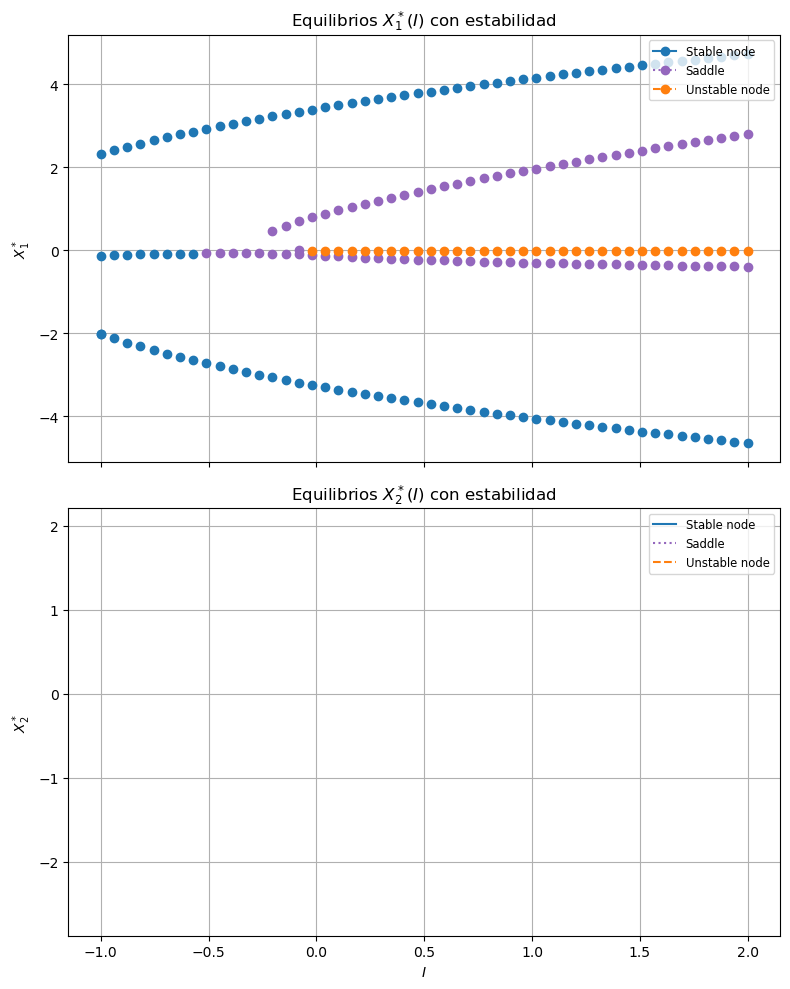

In [319]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


I_vals = np.linspace(-1, 2, 50)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

h = 1e-6  # paso para diferencias finitas
plotted = {'X1': set(), 'X2': set()}

for Iv in I_vals:
    roots = zeros_para_I(Iv)  # [(x1,x2), ...]
    # Para cada raíz en este I
    for x1, x2 in roots:
        # Jacobiano numérico
        J = np.array([
            [
                (F1_num(x1+h, x2, Iv, Iv, Iv) - F1_num(x1-h, x2, Iv, Iv, Iv)) / (2*h),
                (F1_num(x1, x2+h, Iv, Iv, Iv) - F1_num(x1, x2-h, Iv, Iv, Iv)) / (2*h)
            ],
            [
                (F2_num(x1+h, x2, Iv, Iv, Iv) - F2_num(x1-h, x2, Iv, Iv, Iv)) / (2*h),
                (F2_num(x1, x2+h, Iv, Iv, Iv) - F2_num(x1, x2-h, Iv, Iv, Iv)) / (2*h)
            ]
        ], float)

        stab = stability(J)

        ax1.plot([Iv], [x1],
                 marker ='o',
                 linestyle=STABILITY_STYLE[stab],
                 color=EQUILIBRIUM_COLOR[stab],
                 label=(stab if stab not in plotted['X1'] else '_nolegend_'))
        ax2.plot([Iv], [x2],
                 linestyle=STABILITY_STYLE[stab],
                 color=EQUILIBRIUM_COLOR[stab],
                 label=(stab if stab not in plotted['X2'] else '_nolegend_'))

        plotted['X1'].add(stab)
        plotted['X2'].add(stab)

# Ajustes finales
ax1.set_title('Equilibrios $X_1^*(I)$ con estabilidad')
ax1.set_ylabel('$X_1^*$')
ax1.grid(True)
ax1.legend(loc='upper right', fontsize='small')

ax2.set_title('Equilibrios $X_2^*(I)$ con estabilidad')
ax2.set_xlabel('$I$')
ax2.set_ylabel('$X_2^*$')
ax2.grid(True)
ax2.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()
